In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scaling_lib.ftutils_torch as ftutils
import matplotlib.pyplot as plt

In [21]:
from scaling_lib.split_step_solver import BPMSplitStepSolver
from scaling_lib.waveguide import Waveguide
from scaling_lib.helpers import smoothen1d, gaussian, add_absorbing_boundary, timestring, L2, has_converged
from scaling_lib.mode_solver import solve_modes
from scaling_lib.pat import make_pat_func
from scaling_lib import pnn_utils 

# Main

In [22]:
Nmodes = 10

# waveguide parameters
λ0 = 1.55 # free-space wavelength, all lengths are in um
k0 = 2*np.pi/λ0
neff = 1.8 # effective index of slab mode

# x-axis
Lx = 500 # width of simulation area (transverse dimension)
Nx = 2**9 # number of pixels in transverse dimensions
dx = Lx/(Nx-1) # stepsize in transverse dimension
x_axis = ftutils.ft_t_axis(Nx, dx)

# z-axis
dz = 10 # propagation step in z-direction
Lz = 10000 # length of device in propagation-direction
Nz = int(np.floor(Lz/dz))
z_axis = (torch.arange(Nz)+1)*dz

# mode properties
mode_x_min = -150 # center position of leftmost mode
mode_x_max = 150 # center position of rightmost mode
mode_sigma = 6 # standard deviation of gaussian mode

# training parameters
delta_n_val = 10e-3 # maximal refractive index change
seed = 1 # seed used when sampling random unitary
iterations = 100 # number of training epochs
lr = 0.5e-1 # learning rate

In [23]:
# Define the background delta n of the multimode waveguide
# Since we want to simulate a slab waveguide, we set the real part of background_delta_n to zero
# and add absorbing boundary conditions
background_delta_n = torch.zeros(Nx, dtype = torch.complex64)
background_delta_n = add_absorbing_boundary(x_axis, background_delta_n, k0, abs_width=50, sigma_max = 0.001)
# The waveguide class is just a convenient way of storing all parameters associated with the waveguide
# It doesn't do anything beyond that
wg = Waveguide(neff, x_axis, z_axis, background_delta_n)

Text(0.5, 1.0, 'Flat index profile (slab waveguide)')

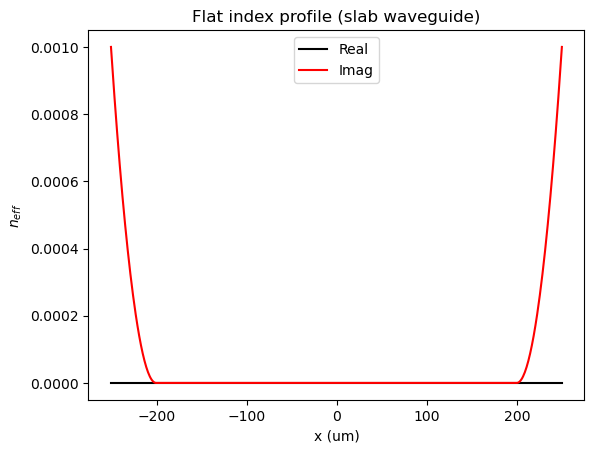

In [24]:
plt.plot(x_axis, background_delta_n.real, c='k', label = 'Real')
plt.plot(x_axis, background_delta_n.imag, c='r', label = 'Imag')
plt.xlabel('x (um)')
plt.ylabel(r'$n_{eff}$')
plt.legend()
plt.title('Flat index profile (slab waveguide)')

In [25]:
# We use Gaussian beams as our "modes"
modes = torch.vstack([gaussian(x_axis, mu, mode_sigma) for mu in np.linspace(mode_x_min, mode_x_max, Nmodes)])

Text(0.5, 1.0, 'Waveguide modes')

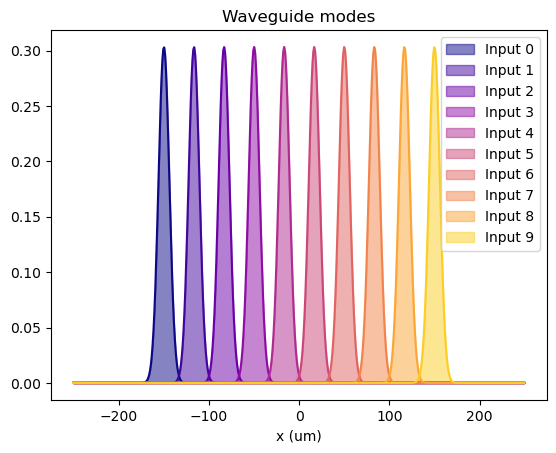

In [26]:
import matplotlib.cm as cm

for ind_mode, mode in enumerate(modes):
    plt.fill_between(x_axis, mode, label = f'Input {ind_mode}', color = cm.plasma(ind_mode/Nmodes), alpha = 0.5)
    plt.plot(x_axis, mode, color = cm.plasma(ind_mode/Nmodes))

plt.legend(loc = 'upper right')
plt.xlabel('x (um)')
plt.title('Waveguide modes')

In [27]:
# Set up the split step solver which will integrate the PDE
bpmsolver = BPMSplitStepSolver(x_axis, z_axis, neff)

# Inverse design

In [28]:
class TDwgNet(nn.Module):
    def __init__(self, solver, wg, delta_n_val, modes, device, mode = 'insilico', wg_backward = None):
        super(TDwgNet, self).__init__()
        self.device = device
        
        mod = torch.zeros([wg.Nz, wg.Nx], requires_grad=True, dtype=torch.float32).to(self.device)
        self.mod = pnn_utils.Parameter(mod, limits=[-0.45, 0.45]) 
        self.delta_n_val = delta_n_val
        
        self.input_modes = modes.to(dtype=torch.complex128).to(self.device)
        self.output_modes = modes.to(dtype=torch.complex128).to(self.device)
        
        self.wg = wg
        self.solver = solver
        
        if wg_backward: self.wg_backward = wg_backward
        else: self.wg_backward = wg
            
        if mode == 'pat': self.f_pat = make_pat_func(self.forward_internal, self.backward_internal)
        if mode == 'insilico': self.f_pat = self.forward_internal

    def forward(self, x):
        a_out = self.f_pat(x)
        return a_out

    def forward_internal(self, x):
        mod = self.mod
        mod = mod.clip(0, 1)

        inputs = x.to(self.device) @ self.input_modes
        
        delta_n = self.wg.background_delta_n + self.delta_n_val*mod
        output_beams = self.solver.run_simulation(inputs, delta_n)
        
        a_out = output_beams@self.output_modes.T*dx
        return a_out
        
    def backward_internal(self, x):
        mod = self.mod
        mod = mod.clip(0, 1)

        inputs = x.to(self.device) @ self.input_modes
        
        delta_n = self.wg.background_delta_n + self.delta_n_val*mod
        output_beams = self.solver.run_simulation(inputs, delta_n)
        
        a_out = output_beams@self.output_modes.T*dx
        return a_out

In [29]:
def run_training_loop(tdwg_pnn, U_target, iterations, lr, batch_size, device, gamma=0.99, print_interval=1):
    optimizer = optim.Adam(tdwg_pnn.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    U_target = U_target.to(device)
    loss_list = []
    
    n = len(tdwg_pnn.input_modes)  # length of the original vector
    indices = np.arange(n)
    batch_indices = np.array_split(indices, np.ceil(n / batch_size))  # Split into subvectors

    tdwg_pnn.train()
    for i in range(iterations):
        optimizer.zero_grad()

        for indices in batch_indices:
            U_num = tdwg_pnn.forward(torch.eye(n, dtype = torch.complex128)[indices])
            l_objective = L2(U_target[indices], U_num)
    
            l_lagrange = pnn_utils.lagrangian(tdwg_pnn, lag_amp = 1, factor = 20)
            l = l_objective + l_lagrange 
            # l = l_objective
            l.backward()
            
        optimizer.step()
        scheduler.step()
        loss_list.append(l.detach().cpu().data)

        if i % print_interval == 0:
            print(timestring() + f"--Iteration: {i}, Loss: {l.detach().cpu().data:.5f}")
            # get_cpu_memory_usage(threshold_gb = 0.01)
            # get_gpu_memory_usage(threshold_gb = 0.01)
        if has_converged(loss_list):
            print(timestring() + f"Converged at iteration: {i}, Loss: {l.detach().cpu().data:.5f}")
            break
    return loss_list

In [30]:
from scipy.stats import unitary_group

In [31]:
U_target = unitary_group.rvs(Nmodes, random_state=seed)
U_target = torch.tensor(U_target)

In [32]:
tdwg_pnn = TDwgNet(bpmsolver, wg, delta_n_val, modes, 'cpu')

In [33]:
loss_list = run_training_loop(tdwg_pnn, U_target, iterations, lr, batch_size = 10, device = 'cpu', print_interval=20)

C:\Users\MartinStein\OneDrive - Yale University\Work\Github\2D-waveguide-demo-code\scaling_lib_new\split_step_solver.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dz = torch.tensor(self.dz, device=device, dtype=delta_n.dtype)


2025-07-10--19-30-20--Iteration: 0, Loss: 0.63548
2025-07-10--19-30-53--Iteration: 20, Loss: 0.16700
2025-07-10--19-31-24--Iteration: 40, Loss: 0.02740
2025-07-10--19-31-58--Iteration: 60, Loss: 0.01635
2025-07-10--19-32-14Converged at iteration: 70, Loss: 0.01426


Text(0, 0.5, 'Loss')

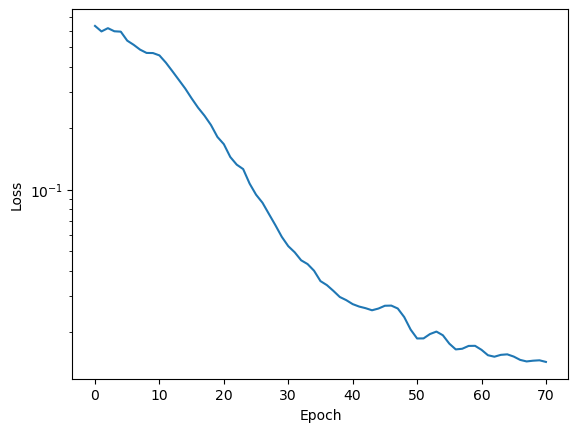

In [34]:
plt.plot(loss_list)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [35]:
with torch.no_grad():
    U_num_inv = tdwg_pnn(torch.eye(Nmodes, dtype = torch.complex128))

In [36]:
avg_error_inv = torch.mean(torch.abs(U_num_inv-U_target))/torch.mean(torch.abs(U_target)) * 100
print(f"Average error for inverse design: {avg_error_inv:.2f}%")

Average error for inverse design: 8.73%


## Plot inverse design results

In [37]:
def plot_delta_n(z_axis, x_axis, delta_n, vmax):
    figsize_deltan = (3, 1.5*3/5)
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    img = plt.pcolormesh(z_axis/1000, x_axis, np.real(delta_n.T), cmap="coolwarm", vmax=vmax, vmin=-vmax)
    plt.ylim(x_axis.min(), x_axis.max())
    plt.xlabel("z (mm)")
    plt.ylabel("x (um)")
    plt.title(r"$\Delta n(x, z)$")

    visible_ticks = [tick for tick in ax.get_xticks() if ax.get_xlim()[0] <= tick <= ax.get_xlim()[1]]
    visible_ticks = [0] + visible_ticks  # Add 0 to the visible ticks
    ax.set_xticks(visible_ticks)

    # Create a separate figure for the colorbar
    fig_cbar = plt.figure(figsize=(0.1, figsize_deltan[1]))
    cbar = plt.colorbar(img, cax=plt.gca())
    cbar.set_label(r'$\Delta n$', rotation=270, labelpad=5)  # Reduced labelpad from 15 to 5
    
    # Display both figures
    plt.show()

C:\Users\MartinStein\AppData\Local\Temp\ipykernel_41612\2148474590.py:16: UserWarning: Adding colorbar to a different Figure <Figure size 600x180 with 1 Axes> than <Figure size 10x90 with 1 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(img, cax=plt.gca())


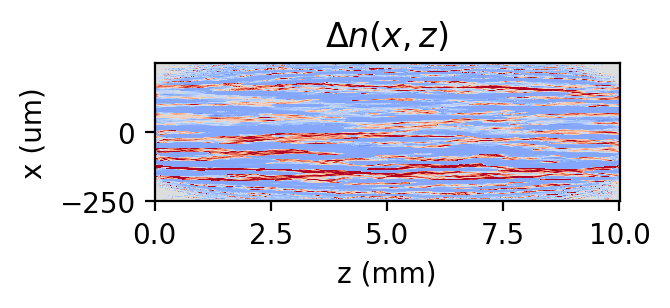

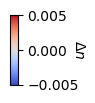

In [38]:
delta_n_inv = delta_n_val*(torch.clip(tdwg_pnn.mod.detach(), -0.5, 0.5))
plot_delta_n(wg.z_axis, wg.x_axis, delta_n_inv, delta_n_val/2)

In [39]:
vmax = U_target.abs().max()

In [40]:
def plot_unitary(U, vmax, title, colorbar_flag=True):
    figsize_U = (1.3, 1.3)
    
    # Plot main figure
    fig_main, ax = plt.subplots(figsize=figsize_U, dpi=200)
    img = plt.imshow(np.abs(U), cmap="bone_r", vmax=vmax)
    plt.title(title)
    plt.xticks([0, 2, 4, 6, 8])
    
    if colorbar_flag:
        # Create a separate figure for the colorbar
        fig_cbar = plt.figure(figsize=(0.1, figsize_U[1]))
        cbar = plt.colorbar(img, cax=plt.gca())
    
    # Display figures
    plt.show()

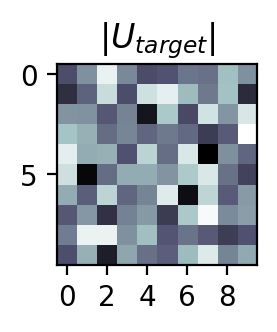

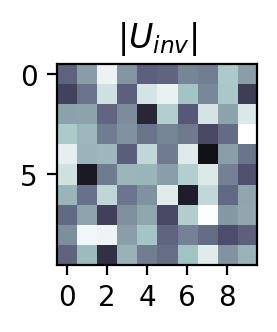

C:\Users\MartinStein\AppData\Local\Temp\ipykernel_41612\1794313030.py:13: UserWarning: Adding colorbar to a different Figure <Figure size 260x260 with 1 Axes> than <Figure size 10x130 with 1 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(img, cax=plt.gca())


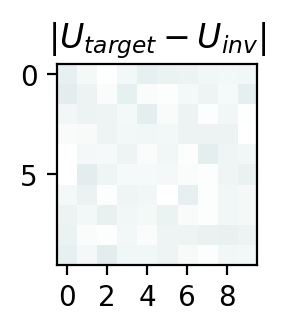

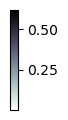

In [41]:
plot_unitary(U_target, vmax, r"$|U_{target}|$", colorbar_flag=False)
plot_unitary(U_num_inv, vmax, r"$|U_{inv}|$", colorbar_flag=False)
plot_unitary(np.abs(U_num_inv-U_target), vmax, r"$|U_{target}-U_{inv}|$", colorbar_flag=True)